In [1]:
import torch, pickle, time,os
import numpy as np
import matplotlib.pyplot as plt
import torch_geometric as tg
from torch_geometric.loader import DataLoader
# if torch.cuda.is_available():
#     from accelerate import Accelerator
#     accelerator = Accelerator()
#     device = accelerator.device
### accelerate huggingface to GPU

In [2]:
os.listdir('../../../../scratch/gpfs/cj1223/GraphStorage/')

['medium_beforeafter',
 'medium_all_q_diffbeforeafter',
 'medium_all_smass',
 'test_beforeafter',
 'test_all_smass',
 'transformers',
 'medium_all_variance',
 'medium_all_q',
 'test_variance',
 'small_all_q_variancehalomass',
 'medium_all_residual',
 'medium_all',
 'test',
 'med_all_residual',
 'one_all_q',
 '105lim_all_smass',
 'small_all_q']

In [5]:
case='medium_all_variance'
# case='small_all_q_variancehalomass'
data=pickle.load(open(f'../../../../scratch/gpfs/cj1223/GraphStorage/{case}/data.pkl', 'rb'))
print(len(data))

20311


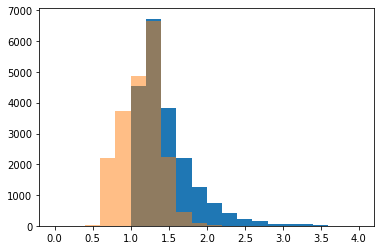

In [12]:
x,y, ls=[], [], []
for d in data:
    x.append(d.x[0,3].numpy())
    y.append(d.y.numpy())   
    ls.append(len(d.x.numpy()))
plt.hist(np.hstack(x), bins=20, range=[0,4])
plt.hist(np.hstack(y), bins=20, range=(0,4), alpha=0.5);

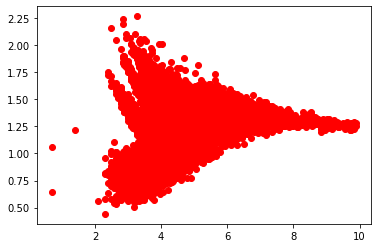

In [16]:
plt.plot(np.log(ls),y, 'ro')

In [17]:
import torch.nn.functional as F
from torch.nn import Linear, BatchNorm1d
from torch_geometric.nn import SAGEConv, global_mean_pool, norm, global_max_pool, global_add_pool


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels, nlin=3):
        super(GCN, self).__init__()
        
        self.conv1 = SAGEConv(data[0].num_node_features, hidden_channels) ##use meta-layer
        ## https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.meta.MetaLayer
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        
        # Our final linear layer will define our output
        self.bn = BatchNorm1d(num_features=hidden_channels) # layer_norm instead
        self.lin1 = Linear(hidden_channels, 1)
        
    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
#         x = self.conv3(x, edge_index)   

          # 2. Readout layer
#         x = global_max_pool(x, batch)  ## Miles says use sumpool
#         x = global_mean_pool(x, batch)
#         x=concat(x1,x2)
        x = global_add_pool(x, batch)  ## Miles says use sumpool

#         x = F.dropout(x, p=0.1, training=self.training)

        x = self.lin1(self.bn(x))
#         x=self.lin1(x)
        return x
    
model = GCN(hidden_channels=32)
next(model.parameters()).is_cuda ##check number one

False

In [18]:
criterion = torch.nn.MSELoss()
n_epochs=200
batch_size=64
split=0.8
np.random.shuffle(data)
test_data=data[int(len(data)*split):]
train_data=data[:int(len(data)*split)]

In [19]:
train_loader=DataLoader(train_data, batch_size=batch_size, shuffle=1)
test_loader=DataLoader(test_data, batch_size=batch_size, shuffle=1)    
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)
# _, _, test_loader = accelerator.prepare(model, optimizer, train_loader)
# model, optimizer, train_loader = accelerator.prepare(model, optimizer, train_loader)

# Initialize our train function
def train():
    model.train()
 
    for data in train_loader:  
        out = model(data.x, data.edge_index, data.batch)  
        loss = criterion(out, data.y.view(-1,1)) 
        loss.backward()
#         accelerator.backward(loss)
        optimizer.step() 
        optimizer.zero_grad() 
 # test function
def test(loader):
    model.eval()
 
    correct = 0
    for dat in loader: 
        out = model(dat.x, dat.edge_index, dat.batch) 
#         print(out)
        correct += (torch.square(out - dat.y.view(-1,1))).sum() 
    return correct / len(loader.dataset) 
tr_acc, te_acc=[],[]
start=time.time()
for epoch in range(n_epochs):
    train()
    
    if (epoch+1)%5==0:
        train_acc = test(train_loader)
        test_acc = test(test_loader)
        tr_acc.append(train_acc.detach().numpy())
        te_acc.append(test_acc.detach().numpy())
        print(f'Epoch: {epoch+1:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')
stop=time.time()
spent=stop-start
print(f"{spent:.2f} seconds spent training, {spent/n_epochs:.3f} seconds per epoch. Processed {len(data)*split*n_epochs/spent:.0f} trees per second")

Epoch: 005, Train Acc: 0.0338, Test Acc: 0.0329
Epoch: 010, Train Acc: 0.0423, Test Acc: 0.0384
Epoch: 015, Train Acc: 0.0289, Test Acc: 0.0258
Epoch: 020, Train Acc: 0.0271, Test Acc: 0.0308
Epoch: 025, Train Acc: 0.0261, Test Acc: 0.0290
Epoch: 030, Train Acc: 0.0232, Test Acc: 0.0237
Epoch: 035, Train Acc: 0.0250, Test Acc: 0.0291
Epoch: 040, Train Acc: 0.0288, Test Acc: 0.0357
Epoch: 045, Train Acc: 0.0267, Test Acc: 0.0335
Epoch: 050, Train Acc: 0.0233, Test Acc: 0.0293
Epoch: 055, Train Acc: 0.0216, Test Acc: 0.0255
Epoch: 060, Train Acc: 0.0204, Test Acc: 0.0266
Epoch: 065, Train Acc: 0.0204, Test Acc: 0.0255
Epoch: 070, Train Acc: 0.0262, Test Acc: 0.0293
Epoch: 075, Train Acc: 0.0200, Test Acc: 0.0266
Epoch: 080, Train Acc: 0.0189, Test Acc: 0.0242
Epoch: 085, Train Acc: 0.0205, Test Acc: 0.0291
Epoch: 090, Train Acc: 0.0197, Test Acc: 0.0262
Epoch: 095, Train Acc: 0.0230, Test Acc: 0.0269
Epoch: 100, Train Acc: 0.0206, Test Acc: 0.0248
Epoch: 105, Train Acc: 0.0191, Test Acc:

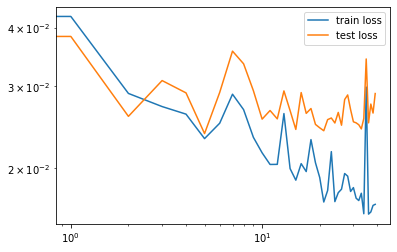

In [20]:
plt.plot(tr_acc, label='train loss')
plt.plot(te_acc, label='test loss')
plt.yscale('log')
plt.xscale('log')
plt.legend()

In [22]:
ys, pred=[],[]
def test(loader):
    model.eval()
 
    correct = 0
    for dat in loader:  # Iterate in batches over the training/test dataset.
        out = model(dat.x, dat.edge_index, dat.batch) 
#         print(out.view(1,-1).detach().numpy())
        pred.append(out.view(1,-1).detach().numpy())
        ys.append(np.array(dat.y)) # Check against ground-truth labels.
#     return correct / len(loader.dataset)  # Derive ratio of correct predictions.
test(test_loader)
test(train_loader)
ys=np.hstack(ys)
pred=np.hstack(pred)[0]

[Text(0.5, 1.0, 'Residuals, scatter is 0.14'),
 Text(0.5, 0, 'log($\\sigma_M$)')]

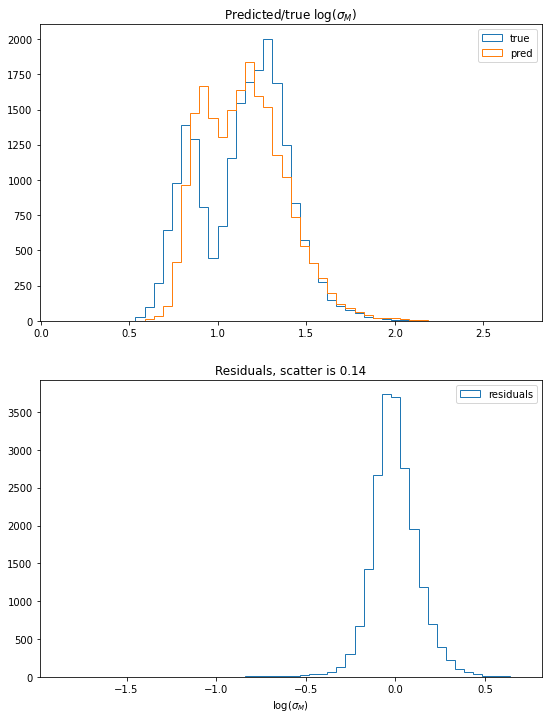

In [23]:
fig, ax= plt.subplots(2, figsize=(9,12))
bins=50
ax[0].hist(ys, bins=bins, range=(np.min(np.hstack([ys,pred]))/1.5,np.max(np.hstack([ys,pred]))/1.5), label='true',  histtype='step')
ax[0].hist(pred, bins=bins, range=(np.min(np.hstack([ys,pred]))/1.5,np.max(np.hstack([ys,pred]))/1.5), label='pred', histtype='step')
ax[1].hist((ys-pred), bins=bins,range=(np.min((ys-pred))/1.5,np.max((ys-pred))/1.5),  histtype='step', label='residuals');
ax[0].legend()
ax[1].legend()
ax[0].set(title=r'Predicted/true log($\sigma_M$)')
ax[1].set(title=f'Residuals, scatter is {np.std(ys-pred):.2f}', xlabel=r'log($\sigma_M$)')

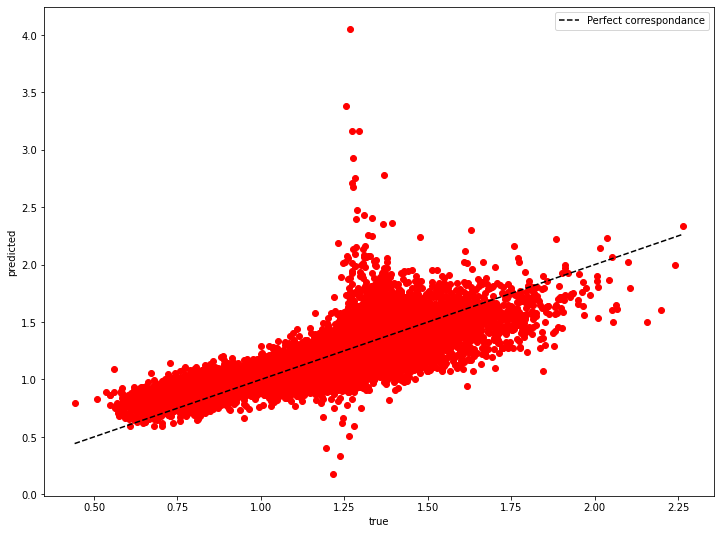

In [24]:
fig, ax =plt.subplots(figsize=(12,9))
ax.plot(ys,pred, 'ro')
ax.plot([min(ys),max(ys)],[min(ys),max(ys)], 'k--', label='Perfect correspondance')
ax.set(xlabel='true',ylabel='predicted')
ax.legend()

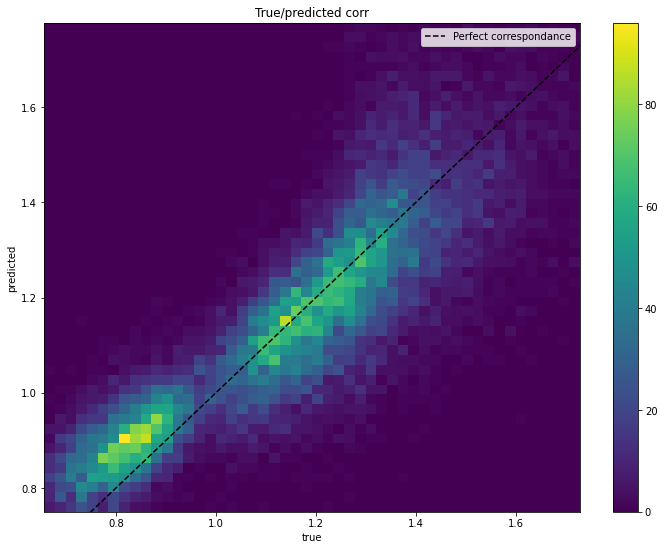

In [25]:
fig, ax =plt.subplots(figsize=(12,9))
h = ax.hist2d(ys,pred, bins=50, range=[np.percentile(ys, [1,99]),np.percentile(pred, [1,99])])
fig.colorbar(h[3], ax=ax)
ax.plot([min(ys),max(ys)],[min(ys),max(ys)], 'k--', label='Perfect correspondance')
ax.set(xlabel='true',ylabel='predicted', title='True/predicted corr')
ax.legend()

In [34]:
x,y=[], []
for d in data:
    x.append(d.x[0,3].numpy())
    y.append(d.y.numpy())    

(array([4.613e+03, 2.461e+03, 1.547e+03, 7.540e+02, 4.860e+02, 2.860e+02,
        1.410e+02, 1.150e+02, 3.500e+01, 2.400e+01, 3.400e+01, 1.300e+01,
        5.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 7.000e+00]),
 array([1.1073781, 1.3119761, 1.516574 , 1.721172 , 1.92577  , 2.130368 ,
        2.334966 , 2.539564 , 2.7441618, 2.9487598, 3.1533577, 3.3579557,
        3.5625536, 3.7671516, 3.9717498, 4.1763477, 4.3809457, 4.5855436,
        4.7901416, 4.9947395, 5.1993375], dtype=float32),
 <BarContainer object of 20 artists>)

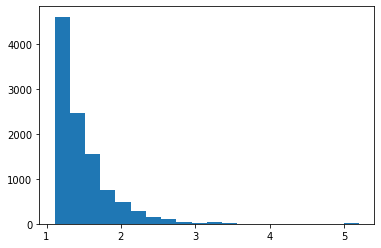

In [35]:
plt.hist(np.hstack(x), bins=20)

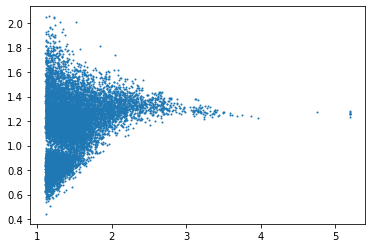

In [36]:
plt.plot(x, y, 'o', markersize=1)